In [53]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(17,6)});
sns.set(style='whitegrid')

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(17,6)});
sns.set(style='whitegrid')

In [3]:
df = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])

print(df.shape)
df.head()

(2625, 1)


,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


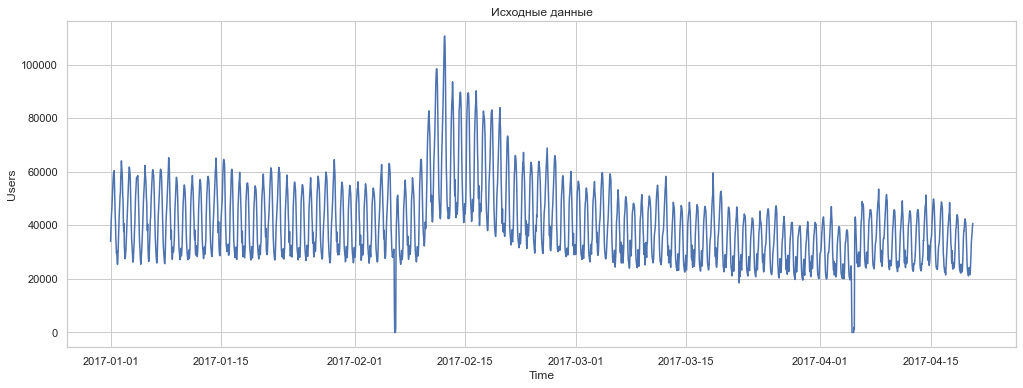

In [4]:
sns.lineplot(x=df.index, y='Users', data=df);
#plt.xticks(rotation=45)
plt.title('Исходные данные');

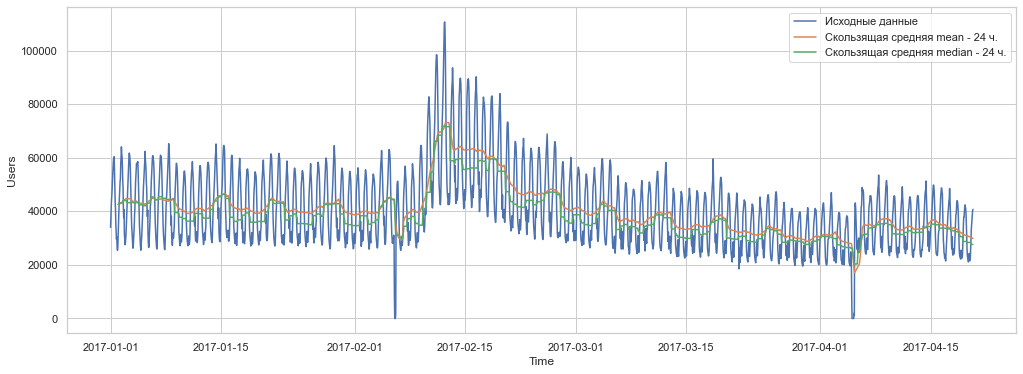

In [5]:
sns.lineplot(x=df.index, y='Users', data=df, label='Исходные данные');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24).mean(), label='Скользящая средняя mean - 24 ч.');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24).median(), label='Скользящая средняя median - 24 ч.');

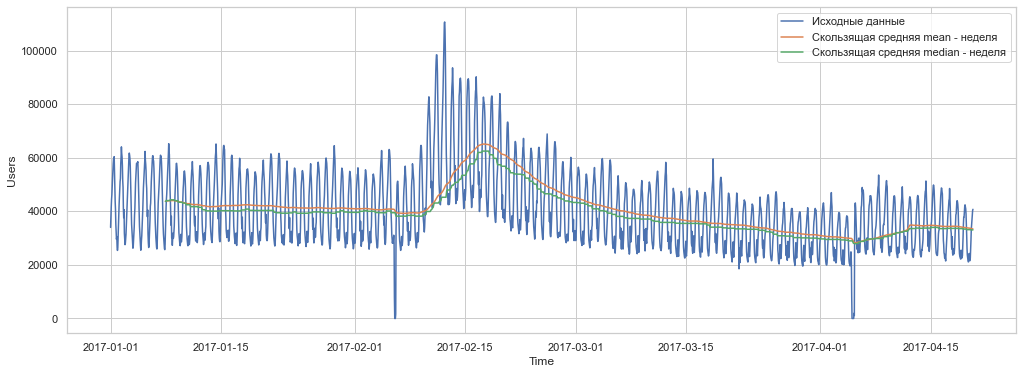

In [6]:
sns.lineplot(x=df.index, y='Users', data=df, label='Исходные данные');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24*7).mean(), label='Скользящая средняя mean - неделя');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24*7).median(), label='Скользящая средняя median - неделя');

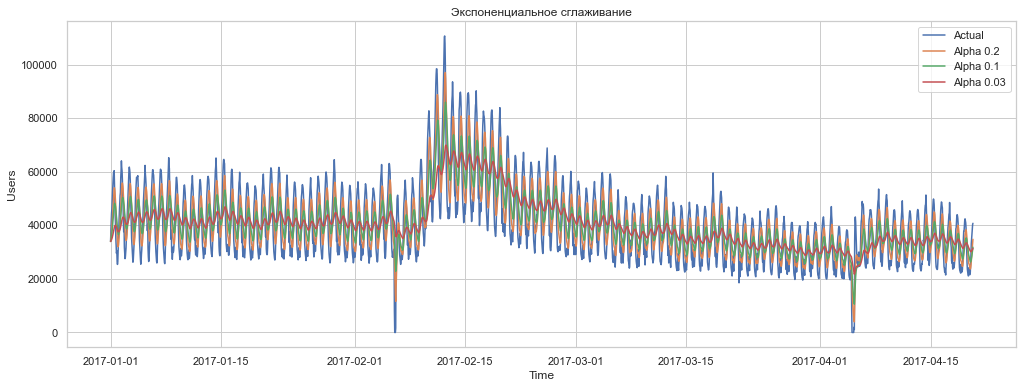

In [35]:
#Экспоненциальное сглаживание
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

sns.lineplot(x=df.index, y=df.Users, label='Исходные данные')

for alpha in [0.2, 0.1, 0.03]:
    sns.lineplot(x=df.index, y=exponential_smoothing(df.Users, alpha), label=f'Alpha {alpha}')

plt.title('Экспоненциальное сглаживание');